# Speed Up DataFrame Operations w/ RAPIDS cuDF

## Welcome
A **DataFrame** is a 2-dimensional data structure used to represent data in a tabular format, like a spreadsheet or SQL table. Originally offered through the Python Data Analysis ([pandas](https://pandas.pydata.org/docs/)) library, DataFrames have become very popular for its familiar representation along with a robust set of features that are intuitive and expressive. 

Raw data often needs to be manipulated before it can be used for further purposes such as generating **Business Intelligence**, creating **Dashboard Visualization**, or training **Machine Learning** models. These preprocessing steps can include **filtering**, **merging**, **grouping**, and **aggregating**. 

Below is a typical data processing pipeline: 
<p><img src='https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/flow.png?raw=true' atl='flow' width=1080></p>

According to [studies](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=29f71b266f63), data preparation accounts for ~80% of the work for analysts. This could be due in part to the rapid increase in the size of data as well as the iterative nature of analytics. 

Recognizing this potential bottleneck, NVIDIA created [**cuDF**](https://docs.rapids.ai/api/cudf/stable/) that leverages GPU hardware and software to perform data manipulation tasks with parallel computing, **saving valuable time and resources**. The cuDF library is part of the larger [**RAPIDS**](https://rapids.ai/) data science framework that allows for the execution of **end-to-end analytics pipelines** entirely on GPUs. One of the focus for cuDF and its companion suite of open source software libraries is to provide syntax that is similar to their CPU counterparts, **making it easy to implement**. 

This notebook is intended to demonstrate speedup in data processing by moving common DataFrame operations to the GPU with minimal changes to existing code. 

### Environment Sanity Check
Check the output of `!nvidia-smi` to make sure you've been allocated a RAPIDS supported GPU such as Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Thu Apr 28 10:37:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Interactive Exercise

In [2]:
import numpy as np # for generating sample data

import pandas as df
# import cudf as df
import time # for clocking process times
import matplotlib.pyplot as plt # for visualizing results

class Timer: # creating a Timer helper class to measure execution time
  def __enter__(self):
    self.start=time.perf_counter()
    return self
  def __exit__(self, *args):
    self.end=time.perf_counter()
    self.interval=self.end-self.start

### Loading a Sample Data
We start our demonstration by generating two 2-dimensional arrays of random numbers - we've configured for sizeable arrays at 1MM rows by 50 columns each. Then they are converted to DataFrames using ```pandas.DataFrame()``` or ```cudf.DataFrame()```:

In [3]:
rows=1000000
columns=50

In [4]:
def load_data(): 
  data_a=np.random.randint(0, 100, (rows, columns))
  data_b=np.random.randint(0, 100, (rows, columns))
  dataframe_a=df.DataFrame(data_a, columns=[f'a_{i}' for i in range(columns)])
  dataframe_b=df.DataFrame(data_b, columns=[f'b_{i}' for i in range(columns)])
  return dataframe_a, dataframe_b

with Timer() as process_time: 
  dataframe_a, dataframe_b=load_data()

print(f'The loading process took {process_time.interval:.2f} seconds')
display(dataframe_a.tail(5))
display(dataframe_b.tail(5))

The loading process took 0.99 seconds


,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,...,a_40,a_41,a_42,a_43,a_44,a_45,a_46,a_47,a_48,a_49
999995,95,25,88,69,62,12,91,2,97,36,...,64,18,34,62,85,31,76,3,32,96
999996,26,75,96,37,10,72,16,1,54,94,...,18,75,11,21,98,70,36,6,10,99
999997,37,18,93,12,84,24,48,94,27,62,...,66,21,54,19,29,35,25,73,33,28
999998,91,90,45,59,15,65,48,59,94,37,...,41,91,21,84,60,56,28,50,16,15
999999,58,36,83,59,31,53,44,65,45,85,...,32,26,0,72,42,42,69,79,88,74


,b_0,b_1,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9,...,b_40,b_41,b_42,b_43,b_44,b_45,b_46,b_47,b_48,b_49
999995,14,57,43,39,60,57,31,3,37,1,...,46,80,20,69,98,4,56,62,17,83
999996,51,19,71,64,17,42,51,68,20,4,...,10,86,46,97,89,52,76,12,32,68
999997,93,99,83,51,72,43,20,8,27,26,...,0,0,90,82,7,30,67,8,9,66
999998,28,61,13,21,0,80,58,48,10,82,...,62,66,89,45,58,26,41,54,72,70
999999,13,23,37,45,95,11,22,52,65,34,...,21,29,48,19,85,16,64,35,36,99


<p><img src='https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/check.png?raw=true' width=720 atl='check'></p>

We created two DataFrames, _dataframe_a_ and _dataframe_b_ that are 1000000 rows by 50 columns (col_1, col_2, ... col_48, col_49) each. 

### Merging Data
Sometimes data can come from multiple sources and need to be merged into one with ```DataFrame.merge()```. For example, a typical retail data storage infrastructure may include a customer table and separate transaction and product tables. Merging the data allows the correct details to be included in a single DataFrame to get the insight needed. 

In [5]:
def merge_data(left_df, right_df):
  combined_df=df.merge(left_df, right_df, left_index=True, right_index=True)
  return combined_df

with Timer() as process_time: 
  combined_df=merge_data(dataframe_a, dataframe_b)

print(f'The merging process took {process_time.interval:.2f} seconds')
display(combined_df.head())

The merging process took 1.25 seconds


,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,...,b_40,b_41,b_42,b_43,b_44,b_45,b_46,b_47,b_48,b_49
0,44,32,41,94,61,38,55,38,10,7,...,22,41,63,72,78,53,41,59,21,51
1,80,6,25,74,50,38,50,2,94,76,...,3,99,75,18,7,1,16,85,70,99
2,94,61,68,53,20,24,28,7,78,48,...,98,22,97,72,69,77,98,55,33,18
3,83,80,9,1,5,72,73,84,58,77,...,44,92,94,36,86,82,19,17,52,80
4,62,84,6,57,73,91,30,69,78,96,...,65,97,63,14,23,37,63,0,5,16


<p><img src='https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/check.png?raw=true' width=720 atl='check'></p>

We merged two DataFrames, _dataframe_a_ and _dataframe_b_ on their _index_ into one larger DataFrame that is 1000000 rows by 100 columns (a_0, a_1, ..., b_48, b_49). 

### Summarize
Exploring data begins with **descriptive statistics**, which often involves finding the **central tendency** and **dispersion**. They are a quick way to summarize distributions. Measures of central tendency includes the mean, median, and mode - they are used to describe the center of a set of data values. Measures of dispersion include variance and standard deviation - they are used to describe the degree to which data is distributed around the center. We can quickly perform simple descriptive statistics with the ```DataFrame.describe()``` method. 

In [6]:
def summarize(dataframe):
  summary_df=dataframe.describe()
  return summary_df

with Timer() as process_time: 
  summary_df=summarize(combined_df)

print(f'The summarizing process took {process_time.interval:.2f} seconds')
display(summary_df)

The summarizing process took 4.56 seconds


,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,...,b_40,b_41,b_42,b_43,b_44,b_45,b_46,b_47,b_48,b_49
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,49.549735,49.525726,49.512794,49.474719,49.506194,49.470701,49.501481,49.438374,49.509852,49.514883,...,49.471831,49.544603,49.545877,49.461511,49.467562,49.534143,49.413073,49.504022,49.519586,49.504389
std,28.865898,28.871482,28.854258,28.873409,28.854247,28.870825,28.866177,28.857090,28.882571,28.866398,...,28.876754,28.862291,28.881922,28.869714,28.861596,28.881029,28.877083,28.894108,28.855053,28.862574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,25.000000,25.000000,24.000000,25.000000,24.000000,25.000000,24.000000,24.000000,25.000000,...,24.000000,25.000000,25.000000,24.000000,24.000000,25.000000,24.000000,24.000000,25.000000,24.000000
50%,50.000000,50.000000,50.000000,49.000000,50.000000,49.000000,49.000000,49.000000,50.000000,50.000000,...,49.000000,50.000000,50.000000,49.000000,49.000000,50.000000,49.000000,49.000000,50.000000,50.000000
75%,75.000000,75.000000,74.000000,75.000000,74.000000,74.000000,74.000000,74.000000,75.000000,75.000000,...,74.000000,75.000000,75.000000,74.000000,74.000000,75.000000,74.000000,75.000000,74.000000,74.000000
max,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000


<p><img src='https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/check.png?raw=true' width=720 atl='check'></p>

Since this is a sample data set, we see that each of columns/features (a_0, a_1, ..., b_48, b_49) have 1000000 values with an average ~50 and standard deviation of ~30

### Correlation - Exploring Relationships
We might be interested in finding relationships/dependencies between two or more variables through their correlation with ```DataFrame.corr()```. Correlation is a number between -1 and 1 that describes the strength of the association between two variables. Two variables with a correlation of 1 suggests that they change together in the same direction while a correlation of -1 suggests that they change together in the opposite direction. 

In [7]:
def correlation(dataframe): 
  corr_df=dataframe.corr()
  return corr_df

with Timer() as process_time: 
  corr_df=correlation(combined_df)

print(f'The correlation process took {process_time.interval:.2f} seconds')
display(corr_df.head())

The correlation process took 23.78 seconds


,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,...,b_40,b_41,b_42,b_43,b_44,b_45,b_46,b_47,b_48,b_49
a_0,1.000000,0.000621,-0.000917,0.000569,0.000613,-0.000464,0.000801,-0.000194,0.000153,0.000666,...,-0.000232,0.000505,0.000662,-0.000774,0.000133,-0.000238,-0.002861,-0.001222,0.000289,-0.001597
a_1,0.000621,1.000000,-0.000659,0.000355,0.001782,0.001279,0.000081,0.000389,0.001044,-0.001556,...,0.000808,-0.001046,-0.002320,-0.000349,-0.000789,-0.000350,0.001053,-0.000797,-0.000697,-0.000447
a_2,-0.000917,-0.000659,1.000000,0.000707,0.001017,-0.000270,0.001471,0.001470,-0.000801,-0.000527,...,-0.001201,0.000182,-0.000949,-0.000952,-0.000444,-0.003557,0.001386,0.001502,0.001312,-0.000585
a_3,0.000569,0.000355,0.000707,1.000000,0.000335,0.000214,-0.000180,0.002099,-0.000198,-0.000977,...,0.000379,0.001256,0.001841,0.001408,-0.000111,0.001999,-0.001763,-0.000369,0.000358,-0.001760
a_4,0.000613,0.001782,0.001017,0.000335,1.000000,0.000083,-0.000065,-0.000683,-0.000049,-0.001001,...,0.000419,-0.000854,0.000365,0.001374,0.002227,0.000615,0.001809,-0.001450,0.000625,0.001466


<p><img src='https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/check.png?raw=true' width=720 atl='check'></p>

The resulting cross tabulation shows that each column/feature (a_0, a_1, ..., b_48, b_49) have a perfect correlation (1) with itself and is not correlated (~0) with each other. 

### Grouping
We can compare subsets of the data to explore the significance of categories and classes with the ```DataFrame.groupby()``` method. We can even group continuous data values into a smaller number of bins with ```pandas.cut()``` or ```cudf.cut()``` to simplify our analysis. The groupings usually follow an aggregation such as mean or count. For example, we can group our data into 5 equidistant bins based on their sequential index. 

In [8]:
def groupby_summarize(dataframe):
    dataframe['group']=dataframe.index
    dataframe['group']=df.cut(dataframe['group'], 5)
    group_describe_df=dataframe.groupby('group').mean().reset_index(drop=True)
    return group_describe_df

with Timer() as process_time: 
    group_describe_df=groupby_summarize(combined_df)

print(f'The grouping process took {process_time.interval:.2f} seconds')
display(group_describe_df)

The grouping process took 1.08 seconds


,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,...,b_40,b_41,b_42,b_43,b_44,b_45,b_46,b_47,b_48,b_49
0,49.486075,49.443370,49.451265,49.446600,49.580670,49.414005,49.523890,49.341445,49.513335,49.441295,...,49.480600,49.562895,49.527295,49.483715,49.514455,49.561995,49.384235,49.563105,49.513055,49.585000
1,49.525860,49.474020,49.549475,49.434720,49.412675,49.572005,49.574260,49.409360,49.474160,49.563290,...,49.499660,49.480650,49.605425,49.355360,49.480620,49.557745,49.417090,49.554655,49.499665,49.449540
2,49.600600,49.532195,49.532000,49.518890,49.552670,49.479815,49.483450,49.479245,49.493680,49.532650,...,49.420115,49.631260,49.454575,49.586435,49.385905,49.514095,49.352565,49.376580,49.449850,49.538260
3,49.686165,49.564570,49.526975,49.491840,49.439240,49.429095,49.373180,49.459385,49.562365,49.549170,...,49.589890,49.552880,49.585990,49.449865,49.490675,49.571930,49.442155,49.535495,49.520855,49.449865
4,49.449975,49.614475,49.504255,49.481545,49.545715,49.458585,49.552625,49.502435,49.505720,49.488010,...,49.368890,49.495330,49.556100,49.432180,49.466155,49.464950,49.469320,49.490275,49.614505,49.499280


<p><img src='https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/check.png?raw=true' width=720 atl='check'></p>

The resulting DataFrame shows that each group maintains an average of ~50 for each column/feature (a_0, a_1, ..., b_48, b_49) as expected for this sample data. 

### Putting it together
We can measure the total elapsed time for this sample data processing workflow. 

In [10]:
def pipeline():
    performance={}
    with Timer() as process_time: 
        dataframe_a, dataframe_b=load_data()
    performance['load data']=process_time.interval
    with Timer() as process_time: 
        combined_df=merge_data(dataframe_a, dataframe_b)
    performance['merge data']=process_time.interval
    with Timer() as process_time: 
        summarize(combined_df)
    performance['summarize']=process_time.interval
    with Timer() as process_time: 
        correlation(combined_df)
    performance['correlation']=process_time.interval
    with Timer() as process_time: 
        groupby_summarize(combined_df)
    performance['groupby & summarize']=process_time.interval
    if df.__name__=='cudf': 
        df.DataFrame([performance], index=['gpu']).to_pandas().plot(kind='bar', stacked=True)
    else: 
        df.DataFrame([performance], index=['cpu']).plot(kind='bar', stacked=True)
    return None

### Timing the Pipeline on CPU

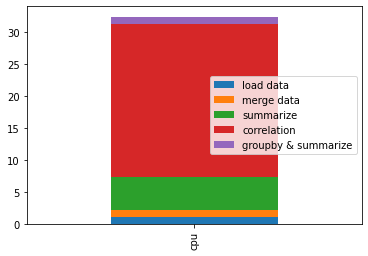

In [11]:
import pandas as df
pipeline()

### Switching to GPU
Traditionally, these tasks are frequently done (as we did) using the popular [**pandas**](https://pandas.pydata.org/) library, which only runs on a single CPU. NVIDIA's [**cuDF**](https://docs.rapids.ai/api/cudf/stable/) library was built with the users in mind - by offering nearly identical syntax to its CPU counterpart, developers only have to make few changes to their existing code to take advantage of its capabilities. 

In [12]:
import cudf as df

**That's it!** cuDF uses nearly identical syntax to the familiar pandas API. **Brilliant!** It's worth noting that there are some features that are unique to each library, but conviniently there are a lot of overlaps. 

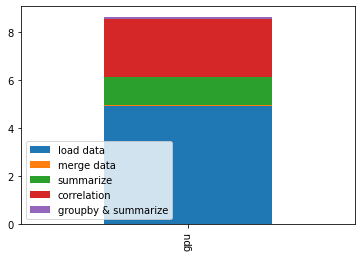

In [13]:
pipeline()

### Comparing Results
In a trial run, **cuDF** completed the data processing tasks in nearly 10x faster than **pandas**. The expectations is that the speedup will be even more significant as the size of the data becomes largers. Feel free to give it a try by modifying the dimensions of the data above. 

![result](https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/result.png?raw=true)

## Conclusion
Congratulations on completing the notebook! Want to learn more about cuDF and the rest of the RAPIDS framework? Check out the follow-up to this course, [Accelerating End-to-End Data Science Workflows]('https://courses.nvidia.com/courses/course-v1:DLI+S-DS-01+V1/about') or our other online courses at [NVIDIA DLI]('https://www.nvidia.com/en-us/training/online/').